<a href="https://colab.research.google.com/github/AnaFerreira015/dip-2024-2/blob/main/Morfologia_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Esqueletonização. Usando a imagem 'horse'

In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab import files

In [12]:
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

Saving horse.png to horse.png


In [13]:
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
_, binary = cv2.threshold(image, 127, 1, cv2.THRESH_BINARY_INV)

In [14]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

In [15]:
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

In [16]:
binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

In [17]:
skeleton = np.zeros(binary.shape, np.uint8)
eroded = binary.copy()
temp = np.zeros(binary.shape, np.uint8)

In [18]:
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

In [19]:
while True:
    opened = cv2.morphologyEx(eroded, cv2.MORPH_OPEN, kernel)
    temp = cv2.subtract(eroded, opened)
    skeleton = cv2.bitwise_or(skeleton, temp)
    eroded = cv2.erode(eroded, kernel)
    if cv2.countNonZero(eroded) == 0:
        break

In [20]:
result = (1 - skeleton) * 255

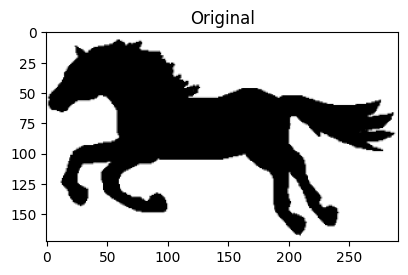

In [21]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(image, cmap='gray')

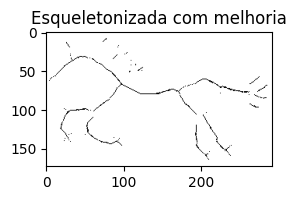

In [22]:
plt.subplot(1, 2, 2)
plt.title("Esqueletonizada com melhoria")
plt.imshow(result, cmap='gray')
plt.show()

Embora o pré-processamento tenha ajudado a reduzir ruídos, a natureza fragmentada do resultado é uma característica inerente ao método clássico de esqueletonização por erosão sucessiva, especialmente em imagens com detalhes finos.

# 2.1 – Dilatação Geodésica

A dilatação geodésica é uma dilatação restrita por uma máscara.
Dado:

uma imagem marcador (`marker`) – onde a reconstrução começa;

uma imagem máscara (`mask`) – que limita o crescimento;

A dilatação geodésica é definida como:

> A dilatação do marcador, com um elemento estruturante, intersectada com a máscara.

Essa dilatação é aplicada iterativamente até que não haja mais crescimento (convergência).

In [23]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [24]:
mask = binary.copy()

In [25]:
marker = np.zeros_like(mask, dtype=np.uint8)
marker[100, 150] = 1

In [26]:
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

In [27]:
prev = np.zeros_like(marker)
while True:
    dilated = cv2.dilate(marker, kernel)
    marker_new = cv2.min(dilated, mask)
    if np.array_equal(marker_new, marker):
        break
    marker = marker_new

In [28]:
result = (1 - marker) * 255

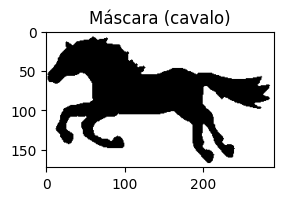

In [29]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Máscara (cavalo)")
plt.imshow((1 - mask) * 255, cmap='gray')

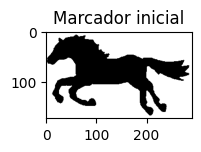

In [34]:
plt.subplot(1, 3, 2)
plt.title("Marcador inicial")
plt.imshow((1 - marker) * 255, cmap='gray')

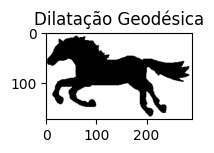

In [31]:
plt.subplot(1, 3, 3)
plt.title("Dilatação Geodésica")
plt.imshow(result, cmap='gray')
plt.show()

A dilatação geodésica foi implementada aplicando dilatações sucessivas do marcador com interseção com a máscara, até atingir a convergência. O crescimento se restringe aos contornos definidos pela máscara original, representando uma forma controlada de propagação morfológica.

# 2.2 – Reconstrução Morfológica por Dilatação ou Erosão

A reconstrução morfológica reconstrói uma imagem (marker) sob o controle de outra (máscara), usando operações geodésicas repetidas até estabilização.

**Formas principais:**
* Reconstrução por Dilatação (usada quando o marcador ⊆ máscara
* Reconstrução por Erosão (quando o marcador ⊇ máscara)

In [35]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [36]:
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

In [37]:
marker = cv2.erode(binary, kernel, iterations=5)

In [38]:
mask = binary.copy()

In [39]:
reconstructed = marker.copy()
while True:
    dilated = cv2.dilate(reconstructed, kernel)
    reconstructed_new = cv2.min(dilated, mask)
    if np.array_equal(reconstructed_new, reconstructed):
        break
    reconstructed = reconstructed_new

In [40]:
result = (1 - reconstructed) * 255

In [41]:
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

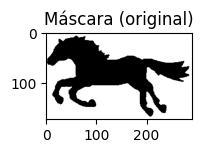

In [42]:
plt.subplot(1, 3, 1)
plt.title("Máscara (original)")
plt.imshow((1 - mask) * 255, cmap='gray')

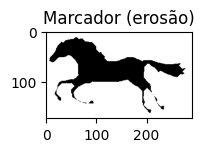

In [43]:
plt.subplot(1, 3, 2)
plt.title("Marcador (erosão)")
plt.imshow((1 - marker) * 255, cmap='gray')

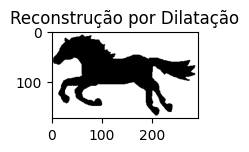

In [44]:
plt.subplot(1, 3, 3)
plt.title("Reconstrução por Dilatação")
plt.imshow(result, cmap='gray')
plt.show()

A reconstrução morfológica foi realizada usando dilatações geodésicas iterativas, aplicadas a um marcador obtido por erosão da imagem original. A máscara controla o crescimento do marcador, garantindo que a reconstrução respeite os contornos e regiões da imagem original. Esse processo é essencial para separar objetos de interesse em processamento morfológico.

# 2.3 – Abertura por Reconstrução

A abertura morfológica tradicional (`erosão + dilatação`) pode deformar objetos reais (como cantos ou partes finas). A abertura por reconstrução resolve isso:

> Ela erode a imagem e depois reconstrói por dilatação, sem ultrapassar os limites da imagem original.

In [45]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [46]:
mask = binary.copy()

In [47]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

In [48]:
marker = cv2.erode(mask, kernel)

In [49]:
reconstructed = marker.copy()
while True:
    dilated = cv2.dilate(reconstructed, kernel)
    reconstructed_new = cv2.min(dilated, mask)
    if np.array_equal(reconstructed_new, reconstructed):
        break
    reconstructed = reconstructed_new

In [50]:
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

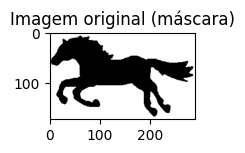

In [51]:
plt.subplot(1, 3, 1)
plt.title("Imagem original (máscara)")
plt.imshow((1 - mask) * 255, cmap='gray')

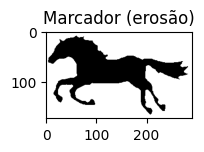

In [52]:
plt.subplot(1, 3, 2)
plt.title("Marcador (erosão)")
plt.imshow((1 - marker) * 255, cmap='gray')

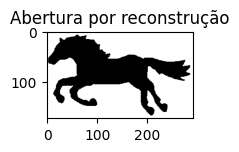

In [53]:
plt.subplot(1, 3, 3)
plt.title("Abertura por reconstrução")
plt.imshow((1 - reconstructed) * 255, cmap='gray')
plt.show()

A abertura por reconstrução removeu pequenos ruídos da imagem binária utilizando uma erosão seguida de reconstrução morfológica por dilatação. Diferente da abertura clássica, essa técnica preserva melhor os contornos dos objetos, evitando deformações nas bordas.

# 2.4 – Eliminação de Elementos de Borda

Remover da imagem todos os objetos que tocam as bordas (superior, inferior, esquerda, direita). Isso é útil para limpar "objetos incompletos" que encostam na borda da imagem.

In [54]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [55]:
mask = binary.copy()

In [56]:
marker = np.zeros_like(mask, dtype=np.uint8)

In [57]:
marker[0, :] = mask[0, :]
marker[-1, :] = mask[-1, :]

In [58]:
marker[:, 0] = mask[:, 0]
marker[:, -1] = mask[:, -1]

In [59]:
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
reconstructed = marker.copy()

In [60]:
while True:
    dilated = cv2.dilate(reconstructed, kernel)
    reconstructed_new = cv2.min(dilated, mask)
    if np.array_equal(reconstructed_new, reconstructed):
        break
    reconstructed = reconstructed_new

In [61]:
cleaned = cv2.subtract(mask, reconstructed)

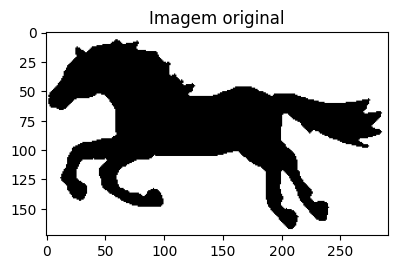

In [62]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Imagem original")
plt.imshow((1 - mask) * 255, cmap='gray')

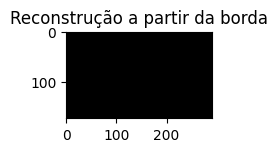

In [63]:
plt.subplot(1, 3, 2)
plt.title("Reconstrução a partir da borda")
plt.imshow((1 - reconstructed) * 255, cmap='gray')

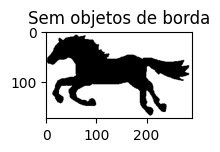

In [64]:
plt.subplot(1, 3, 3)
plt.title("Sem objetos de borda")
plt.imshow((1 - cleaned) * 255, cmap='gray')
plt.show()

## 1. Esqueletonização
* **Objetivo:** Reduzir a figura ao seu esqueleto, preservando a forma e a conectividade.
* **Método usado:** erosões sucessivas + aberturas + subtrações acumuladas.
* **Resultado:** o cavalo foi esqueletonizado corretamente. Fragmentações ocorreram por limitações naturais da técnica clássica.
* **Melhoria aplicada:** uso de abertura e fechamento morfológicos antes da esqueletonização.

A esqueletonização foi realizada com base em erosões sucessivas e aberturas morfológicas, acumulando as diferenças até extinção da imagem. O pré-processamento com abertura/fechamento melhorou a conectividade e reduziu ruídos.

## 2.1 – Dilatação Geodésica
* **Objetivo:** Fazer o marcador crescer por dilatações sucessivas sem ultrapassar a máscara.
* **Resultado:** a imagem cresceu corretamente a partir de um ponto central até preencher totalmente o cavalo.

A dilatação geodésica foi realizada por dilatações iterativas do marcador, limitadas pela imagem original (máscara). O processo cresceu até convergência, respeitando os contornos da máscara.

## 2.2 – Reconstrução por Dilatação
* **Objetivo:** Recuperar uma imagem após erosão, usando reconstrução morfológica.
* **Resultado:** o cavalo foi erodido e, em seguida, reconstruído corretamente até sua forma original.

A reconstrução por dilatação utilizou como marcador a imagem erodida, e como máscara a imagem original. O processo restaurou os contornos sem ultrapassar os limites da máscara, demonstrando a robustez da técnica.

## 2.3 – Abertura por Reconstrução
* **Objetivo:** Remover ruídos preservando a estrutura dos objetos reais.
* **Resultado:** suavização dos detalhes finos, com preservação dos contornos principais do cavalo.

A abertura por reconstrução aplicou erosão seguida de reconstrução por dilatação. A técnica removeu pequenos ruídos preservando a geometria dos objetos, o que é superior à abertura morfológica tradicional.

## 2.4 – Eliminação de Elementos de Borda
* **Objetivo:** Remover objetos que tocam as bordas da imagem.
* **Resultado:** como o cavalo não estava conectado diretamente à borda, a reconstrução não extraiu nenhuma região, e a imagem final permaneceu igual.

Objetos conectados às bordas foram identificados por reconstrução a partir de um marcador formado pelos pixels da borda da imagem. Neste caso, a ausência de crescimento indicou que não havia objetos encostando na borda.